## Skin Low Resolution Greyscale Image Modeling 

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(42)
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

%matplotlib inline

Using TensorFlow backend.


### Reading in the MetaData and Image Files

In [2]:
skin = pd.read_csv('../../datasets/HAM10000_metadata.csv')

Low Resolution Images provide the features

In [3]:
skin_8by8 = pd.read_csv('../../datasets/hmnist_8_8_L.csv')#low res images

Dropping label column(not part of original data) as only pixel data is needed

In [4]:
skin_8by8.drop('label',axis=1, inplace=True)

Joining metadata together with image data to create one DataFrame 192 pixel columns and 7 data columns

In [5]:
skin =pd.concat([skin,skin_8by8],axis = 1)

In [6]:
skin.shape

(10015, 71)

Target Distribution

In [7]:
skin['dx'].value_counts(normalize=True)

nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: dx, dtype: float64

The two diagnoses I want to focus on are melanoma, 11.1% of the total and basal cell carcinoma, 5.1% of the total. To avoid unbalanced classes, take a random sample of the remaining , noncancer diagnosis purposefully not undersampling the 'nv' which is the most challenging to discern from melanoma as well as the largest portion of diagnoses 66.9%.There are 1627 cancer rows, a random sampling of 1627 noncancer rows will be selected.

In [8]:
malignant=skin[(skin['dx']=='mel')| (skin['dx']=='bcc')]
malignant.shape

(1627, 71)

The noncancerous diagnoses are grouped together in the benign subset.

In [9]:
benign= skin[(skin['dx']=='df')|(skin['dx']=='nv')|(skin['dx']=='bkl')|(skin['dx']=='vasc')|(skin['dx']=='akiec')]
benign.shape

(8388, 71)

Shuffling all the rows of the benign diagnosis

In [10]:
benign = benign.sample(benign.shape[0], replace = True)
benign.shape

(8388, 71)

For modeling the malignant diagnosis are converted to ones.

In [11]:
malignant['dx'] =1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
malignant['dx'].value_counts()

1    1627
Name: dx, dtype: int64

For modeling the noncancerous diagnoses are converted to zeroes

In [13]:
benign['dx']=0

In [14]:
benign['dx'].value_counts()

0    8388
Name: dx, dtype: int64

Malignant and a subset of benign are joined together to become skin_equal

In [15]:
skin_equal = pd.concat((malignant,benign.head(1627)))

In [16]:
skin_equal.shape

(3254, 71)

The image_id is unique to each row, it is set as the index

In [17]:
skin_equal.set_index('image_id', inplace = True)

In [18]:
skin_equal.head()

,lesion_id,dx,dx_type,age,sex,localization,pixel0000,pixel0001,pixel0002,pixel0003,...,pixel0054,pixel0055,pixel0056,pixel0057,pixel0058,pixel0059,pixel0060,pixel0061,pixel0062,pixel0063
image_id,,,,,,,,,,,,,,,,,,,,,
ISIC_0025964,HAM_0000871,1,histo,40.0,female,chest,151,165,180,184,...,191,169,163,185,194,196,199,191,180,146
ISIC_0030623,HAM_0000871,1,histo,40.0,female,chest,185,187,192,191,...,199,200,189,192,195,197,196,192,194,197
ISIC_0027190,HAM_0000040,1,histo,80.0,male,upper extremity,135,150,156,161,...,156,152,140,150,135,149,168,158,154,141
ISIC_0031023,HAM_0005678,1,histo,60.0,male,chest,100,186,205,226,...,225,215,135,188,227,242,213,218,232,137
ISIC_0028086,HAM_0005678,1,histo,60.0,male,chest,215,213,244,174,...,243,232,219,232,223,182,242,238,242,236


In [19]:
X = skin_equal.drop(columns=['lesion_id','dx','dx_type',
                    'age', 'sex','localization'])

In [20]:
X.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0054,pixel0055,pixel0056,pixel0057,pixel0058,pixel0059,pixel0060,pixel0061,pixel0062,pixel0063
image_id,,,,,,,,,,,,,,,,,,,,,
ISIC_0025964,151,165,180,184,186,185,180,163,163,180,...,191,169,163,185,194,196,199,191,180,146
ISIC_0030623,185,187,192,191,193,196,191,187,187,192,...,199,200,189,192,195,197,196,192,194,197
ISIC_0027190,135,150,156,161,159,162,158,147,142,137,...,156,152,140,150,135,149,168,158,154,141
ISIC_0031023,100,186,205,226,241,224,222,125,158,198,...,225,215,135,188,227,242,213,218,232,137
ISIC_0028086,215,213,244,174,124,188,242,241,214,207,...,243,232,219,232,223,182,242,238,242,236


In [21]:
y= skin_equal[['dx']]

In [22]:
y.shape

(3254, 1)

Train Test Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)


Making sure to have correct type

In [24]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Changing to numpy array

In [25]:
X_train=X_train.values
X_test=X_test.values

Looking at X_train shape

In [26]:
X_train.shape

(2440, 64)

In [27]:
y_train.shape

(2440, 1)

Looking at X_train first entry

In [28]:
X_train[0]

array([148., 141., 169., 185., 191., 182., 173., 149., 153., 144., 171.,
       194., 188., 181., 181., 163., 156., 161., 189., 198., 193., 187.,
       179., 162., 173., 174., 178., 182., 188., 179., 180., 158., 176.,
       183., 165., 147., 161., 186., 177., 156., 164., 177., 172., 148.,
       143., 174., 170., 152., 160., 166., 170., 159., 159., 162., 152.,
       142., 149., 154., 156., 162., 156., 153., 145., 128.],
      dtype=float32)

In [29]:
# This scales each value to be between 0 and 1. 
X_train/=255
X_test/=255

In [30]:
# Reshape each image to be 8 x 8 x 1.
X_train = X_train.reshape(X_train.shape[0],8,8,1) 
X_test = X_test.reshape(X_test.shape[0],8,8,1) 
# Reshaping your images is often one of the most difficult
# aspects of machine learning with image data.

Checking shape of X_train and y_train now

In [31]:
X_train.shape

(2440, 8, 8, 1)

In [32]:
y_train.shape

(2440, 1)

### Model Construction

Starting with Feed Forward Neural Network

In [33]:
model = Sequential()

model.add(Flatten(input_shape=(8, 8, 1)))

model.add(Dense(128, input_shape=(8, 8, 1), activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(X_train,
                    y_train, 
                    batch_size=256,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 2440 samples, validate on 814 samples
Epoch 1/20
2440/2440 [==============================] - 0s 129us/step - loss: 0.6940 - acc: 0.5041 - val_loss: 0.6886 - val_acc: 0.5246
Epoch 2/20
2440/2440 [==============================] - 0s 14us/step - loss: 0.6865 - acc: 0.5672 - val_loss: 0.6856 - val_acc: 0.5577
Epoch 3/20
2440/2440 [==============================] - 0s 15us/step - loss: 0.6856 - acc: 0.5824 - val_loss: 0.6830 - val_acc: 0.5749
Epoch 4/20
2440/2440 [==============================] - 0s 16us/step - loss: 0.6820 - acc: 0.5947 - val_loss: 0.6817 - val_acc: 0.5627
Epoch 5/20
2440/2440 [==============================] - 0s 15us/step - loss: 0.6808 - acc: 0.5824 - val_loss: 0.6835 - val_acc: 0.5344
Epoch 6/20
2440/2440 [==============================] - 0s 12us/step - loss: 0.6852 - acc: 0.5389 - val_loss: 0.6783 - val_acc: 0.5590
Epoch 7/20
2440/2440 [

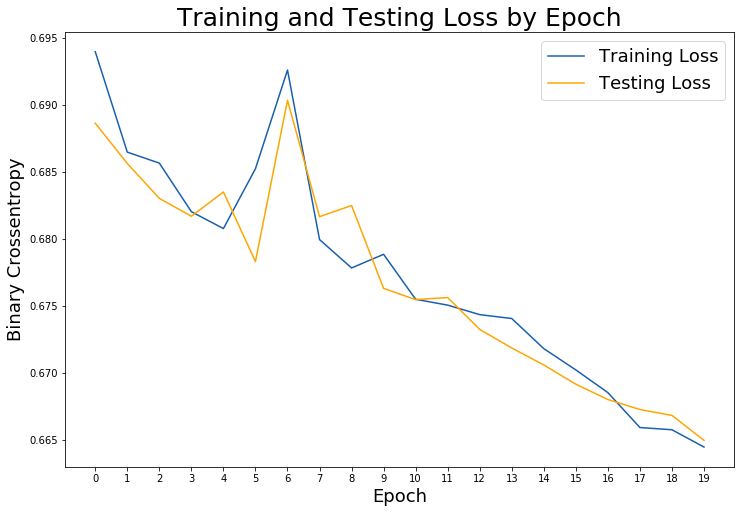

In [34]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

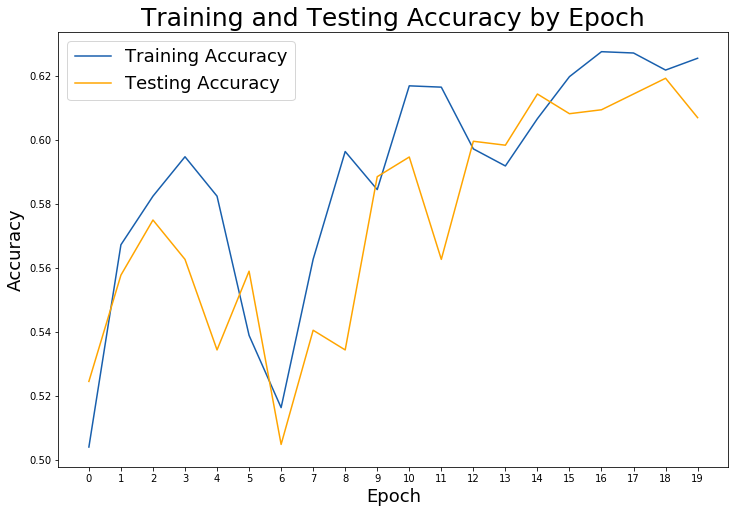

In [35]:
# Check out our train loss and test loss over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

In [36]:
# Evaluate model on test data.
score = model.evaluate(X_test, y_test, verbose=0)
labels = model.metrics_names

# Show model performance.
print(f'{labels[0]}: {score[0]}')
print(f'{labels[1]}: {score[1]}')

model.summary()

loss: 0.6649565991078313
acc: 0.6068796073189532
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 12,481
Trainable params: 12,481
Non-trainable params: 0
_________________________________________________________________


Constructing Convolutional Neural Network

In [37]:
# Instantiate a CNN.
cnn_model = Sequential()

# Add a convolutional layer.

cnn_model.add(Conv2D(filters = 6,     # number of filters
                     kernel_size = 3, # height/width of filter
                     activation = 'relu', # activation function 
                     input_shape = (8, 8, 1))) # shape of input (image)

# dimensions of region of pooling
cnn_model.add(MaxPooling2D(pool_size=(2,2))) 

cnn_model.add(Conv2D(16,
                     kernel_size = 3,
                     activation='relu'))

cnn_model.add(Flatten())

# Add a densely-connected layer with 128 neurons.
cnn_model.add(Dense(128, activation='relu'))

# Add a final layer with 1 neuron.
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

# Fit model on training data
cnn_model.fit(X_train,
              y_train,
              batch_size=256,
              epochs=20,
              verbose=1)

Epoch 1/20
2440/2440 [==============================] - 0s 160us/step - loss: 0.6936 - acc: 0.5041
Epoch 2/20
2440/2440 [==============================] - 0s 24us/step - loss: 0.6932 - acc: 0.4967
Epoch 3/20
2440/2440 [==============================] - 0s 25us/step - loss: 0.6923 - acc: 0.5193
Epoch 4/20
2440/2440 [==============================] - 0s 32us/step - loss: 0.6919 - acc: 0.5361
Epoch 5/20
2440/2440 [==============================] - 0s 24us/step - loss: 0.6922 - acc: 0.5164
Epoch 6/20
2440/2440 [==============================] - 0s 25us/step - loss: 0.6928 - acc: 0.5033
Epoch 7/20
2440/2440 [==============================] - 0s 31us/step - loss: 0.6920 - acc: 0.5139
Epoch 8/20
2440/2440 [==============================] - 0s 29us/step - loss: 0.6927 - acc: 0.5041
Epoch 9/20
2440/2440 [==============================] - 0s 29us/step - loss: 0.6931 - acc: 0.5111
Epoch 10/20
2440/2440 [==============================] - 0s 28us/step - loss: 0.6914 - acc: 0.5287
Epoch 11/20
2440/2

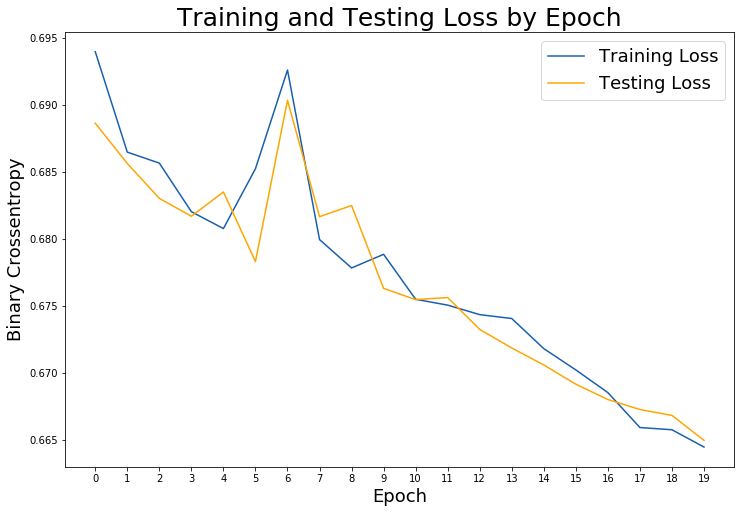

In [38]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

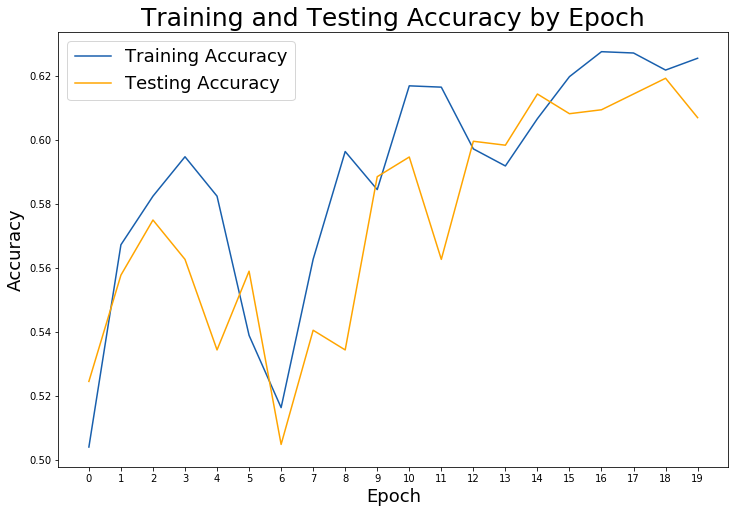

In [39]:
# Check out our train loss and test loss over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

In [40]:
cnn_model.summary()

# Evaluate model on test data
cnn_score = cnn_model.evaluate(X_test, y_test, verbose=0)
cnn_labels = cnn_model.metrics_names

# Compare CNN and FFNN models.
print(f'CNN {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 6, 6, 6)           60        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 6)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 16)          880       
_________________________________________________________________
flatten_2 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 3,245
Trainable params: 3,245
Non-trainable params: 0
_________________________________________________________________
CNN loss

#### Building a second convolutional model

In [41]:
# Instantiate a CNN.
cnn_model_2 = Sequential()

# Add a convolutional layer.
cnn_model_2.add(Conv2D(filters = 16,         # number of filters
                     kernel_size = 3,        # height/width of filter
                     activation='relu',      # activation function 
                     input_shape=(8,8,1))) # shape of input (image)

# Add a pooling layer.
cnn_model_2.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling



# We have to remember to flatten to go from the "box" to the vertical line of nodes!
cnn_model_2.add(Flatten())

# Add a densely-connected layer with 64 neurons.
cnn_model_2.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_2.add(Dropout(0.5))

# Add a densely-connected layer with 16 neurons.
cnn_model_2.add(Dense(16, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_2.add(Dropout(0.5))

# Add a final layer with 1 neuron.
cnn_model_2.add(Dense(1, activation='sigmoid'))

# Compile model
cnn_model_2.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)
# Fit model on training data
cnn_model_2.fit(X_train,
                y_train,
                batch_size=128,
                epochs=20,
                verbose=1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/20
2440/2440 [==============================] - 1s 221us/step - loss: 0.7020 - acc: 0.4820
Epoch 2/20
2440/2440 [==============================] - 0s 40us/step - loss: 0.6950 - acc: 0.4939
Epoch 3/20
2440/2440 [==============================] - 0s 38us/step - loss: 0.6939 - acc: 0.4980
Epoch 4/20
2440/2440 [==============================] - 0s 39us/step - loss: 0.6937 - acc: 0.5045
Epoch 5/20
2440/2440 [==============================] - 0s 40us/step - loss: 0.6925 - acc: 0.5107
Epoch 6/20
2440/2440 [==============================] - 0s 42us/step - loss: 0.6919 - acc: 0.5213
Epoch 7/20
2440/2440 [==============================] - 0s 34us/step - loss: 0.6925 - acc: 0.5057
Epoch 8/20
2440/2440 [==============================] - 0s 43us/step - loss: 0.6917 - acc: 0.5234
Epoch 9/20
2440/2440 [==============================] - 0s 37us/step - loss: 0.6916 - acc: 0.5119
Ep

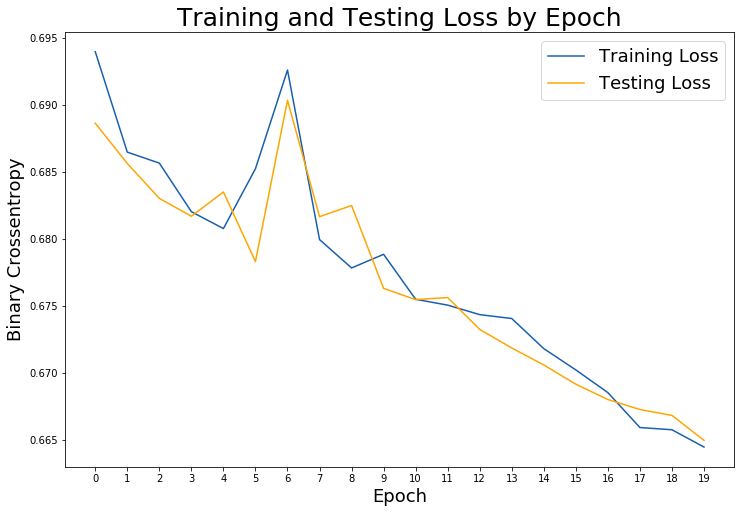

In [42]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

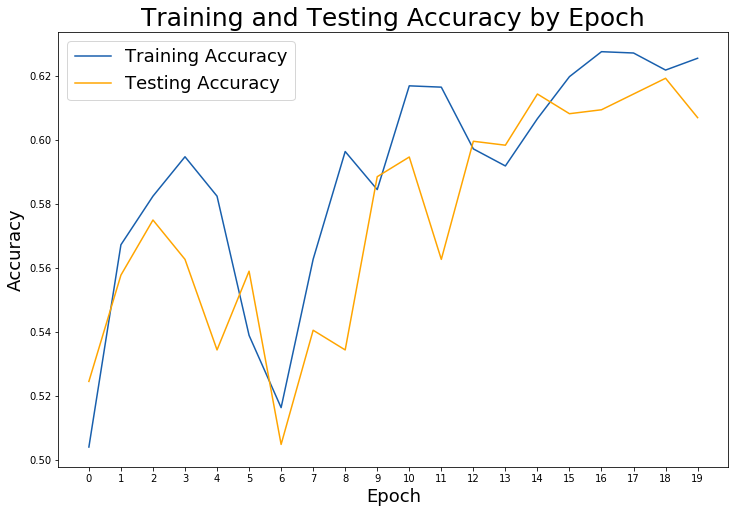

In [43]:
# Check out our train loss and test loss over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

In [44]:
# Evaluate model on test data
cnn_2_score = cnn_model_2.evaluate(X_test, y_test, verbose=0)
cnn_2_labels = cnn_model_2.metrics_names

# Compare models.
print(f'CNN 2 {cnn_2_labels[0]}  : {cnn_2_score[0]}')
print(f'CNN 2 {cnn_2_labels[1]}   : {cnn_2_score[1]}')
print()
print(f'CNN 1 {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN 1 {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

cnn_model_2.summary()

CNN 2 loss  : 0.6678012013435364
CNN 2 acc   : 0.6068796067331581

CNN 1 loss  : 0.6831595730722976
CNN 1 acc   : 0.5921375925769384

FFNN loss : 0.6649565991078313
FFNN acc  : 0.6068796073189532
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 6, 6, 16)          160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                9280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Den

#### Building a third convolutional model

In [45]:
# Instantiate a CNN.
cnn_model_3 = Sequential()

# Add a convolutional layer.
cnn_model_3.add(Conv2D(filters = 16,         # number of filters
                     kernel_size = 3,        # height/width of filter
                     activation='relu',      # activation function 
                     input_shape=(8,8,1))) # shape of input (image)

# Add a pooling layer.
cnn_model_3.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling


# We have to remember to flatten to go from the "box" to the vertical line of nodes!
cnn_model_3.add(Flatten())

# Add a densely-connected layer with 64 neurons.
cnn_model_3.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_3.add(Dropout(0.5))

# Add a densely-connected layer with 32 neurons.
cnn_model_3.add(Dense(32, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_3.add(Dropout(0.5))

# Add a final layer with 1 neuron.
cnn_model_3.add(Dense(1, activation='sigmoid'))

# Compile model
cnn_model_3.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

# Fit model on training data
history = cnn_model_3.fit(X_train,
                          y_train,
                          batch_size=128,
                          validation_data=(X_test, y_test),
                          epochs=20,
                          verbose=1)

Train on 2440 samples, validate on 814 samples
Epoch 1/20
2440/2440 [==============================] - 1s 276us/step - loss: 0.6968 - acc: 0.5045 - val_loss: 0.6916 - val_acc: 0.5762
Epoch 2/20
2440/2440 [==============================] - 0s 46us/step - loss: 0.6954 - acc: 0.4959 - val_loss: 0.6920 - val_acc: 0.5528
Epoch 3/20
2440/2440 [==============================] - 0s 42us/step - loss: 0.6939 - acc: 0.5041 - val_loss: 0.6915 - val_acc: 0.5012
Epoch 4/20
2440/2440 [==============================] - 0s 42us/step - loss: 0.6926 - acc: 0.5160 - val_loss: 0.6911 - val_acc: 0.5098
Epoch 5/20
2440/2440 [==============================] - 0s 38us/step - loss: 0.6931 - acc: 0.4992 - val_loss: 0.6909 - val_acc: 0.5872
Epoch 6/20
2440/2440 [==============================] - 0s 41us/step - loss: 0.6916 - acc: 0.5246 - val_loss: 0.6891 - val_acc: 0.5848
Epoch 7/20
2440/2440 [==============================] - 0s 46us/step - loss: 0.6924 - acc: 0.5115 - val_loss: 0.6895 - val_acc: 0.5663
Epoch 8

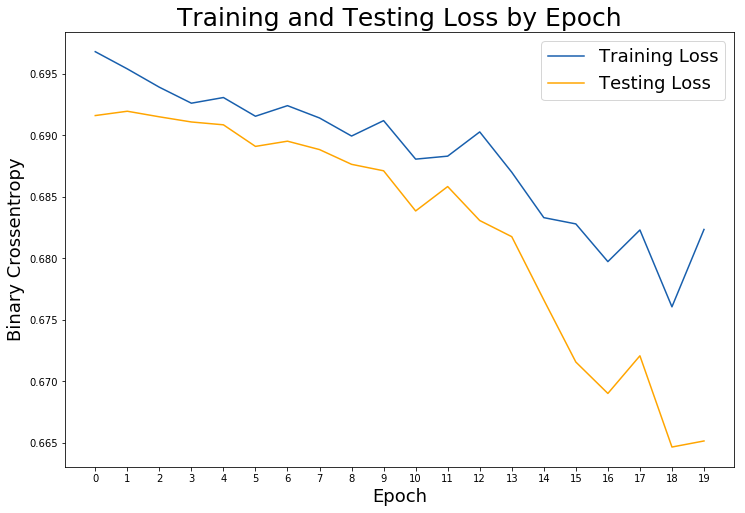

In [46]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

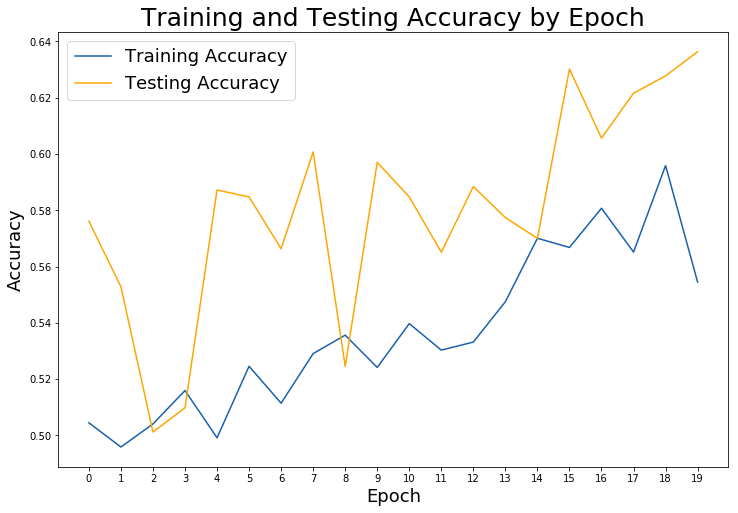

In [47]:
# Check out our train loss and test loss over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

In [48]:
# Evaluate model on test data.
cnn_3_score = cnn_model_3.evaluate(X_test,
                                   y_test,
                                   verbose=1)

cnn_3_labels = cnn_model_3.metrics_names

# Compare models.
print(f'CNN 3 {cnn_3_labels[0]}  : {cnn_3_score[0]}')
print(f'CNN 3 {cnn_3_labels[1]}   : {cnn_3_score[1]}')
print()
print(f'CNN 2 {cnn_2_labels[0]}  : {cnn_2_score[0]}')
print(f'CNN 2 {cnn_2_labels[1]}   : {cnn_2_score[1]}')
print()
print(f'CNN 1 {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN 1 {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

814/814 [==============================] - 0s 49us/step
CNN 3 loss  : 0.6651415101433269
CNN 3 acc   : 0.6363636362171876

CNN 2 loss  : 0.6678012013435364
CNN 2 acc   : 0.6068796067331581

CNN 1 loss  : 0.6831595730722976
CNN 1 acc   : 0.5921375925769384

FFNN loss : 0.6649565991078313
FFNN acc  : 0.6068796073189532


### Fourth Convolutional Model

In [49]:
# Instantiate a CNN.
cnn_model_4 = Sequential()

# Add a convolutional layer.
cnn_model_4.add(Conv2D(filters = 24,         # number of filters
                     kernel_size = 3,        # height/width of filter
                     activation='relu',      # activation function 
                     input_shape=(8,8,1))) # shape of input (image)

                     
# Add a pooling layer.
cnn_model_4.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling


# We have to remember to flatten to go from the "box" to the vertical line of nodes!
cnn_model_4.add(Flatten())

# Add a densely-connected layer with 64 neurons.
cnn_model_4.add(Dense(72, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_4.add(Dropout(0.4))

# Add a densely-connected layer with 32 neurons.
cnn_model_4.add(Dense(48, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_4.add(Dropout(0.4))

# Add a final layer with 1 neuron.
cnn_model_4.add(Dense(1, activation='sigmoid'))

# Compile model
cnn_model_4.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

# Fit model on training data
history = cnn_model_4.fit(X_train,
                          y_train,
                          batch_size=128,
                          validation_data=(X_test, y_test),
                          epochs=20,
                          verbose=1)

Train on 2440 samples, validate on 814 samples
Epoch 1/20
2440/2440 [==============================] - 1s 348us/step - loss: 0.6950 - acc: 0.4996 - val_loss: 0.6926 - val_acc: 0.5086
Epoch 2/20
2440/2440 [==============================] - 0s 48us/step - loss: 0.6963 - acc: 0.4889 - val_loss: 0.6921 - val_acc: 0.5123
Epoch 3/20
2440/2440 [==============================] - 0s 56us/step - loss: 0.6927 - acc: 0.5164 - val_loss: 0.6916 - val_acc: 0.5098
Epoch 4/20
2440/2440 [==============================] - 0s 56us/step - loss: 0.6933 - acc: 0.5025 - val_loss: 0.6901 - val_acc: 0.5786
Epoch 5/20
2440/2440 [==============================] - 0s 61us/step - loss: 0.6907 - acc: 0.5234 - val_loss: 0.6881 - val_acc: 0.5860
Epoch 6/20
2440/2440 [==============================] - 0s 48us/step - loss: 0.6912 - acc: 0.5283 - val_loss: 0.6874 - val_acc: 0.5160
Epoch 7/20
2440/2440 [==============================] - 0s 43us/step - loss: 0.6901 - acc: 0.5352 - val_loss: 0.6855 - val_acc: 0.5553
Epoch 8

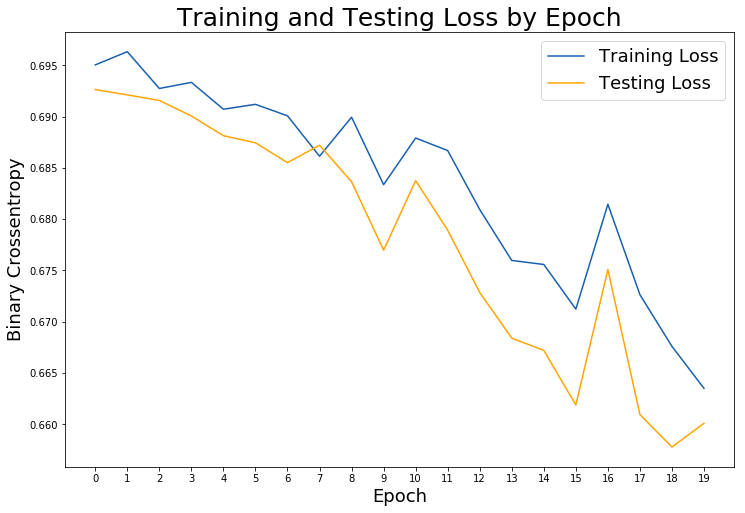

In [50]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

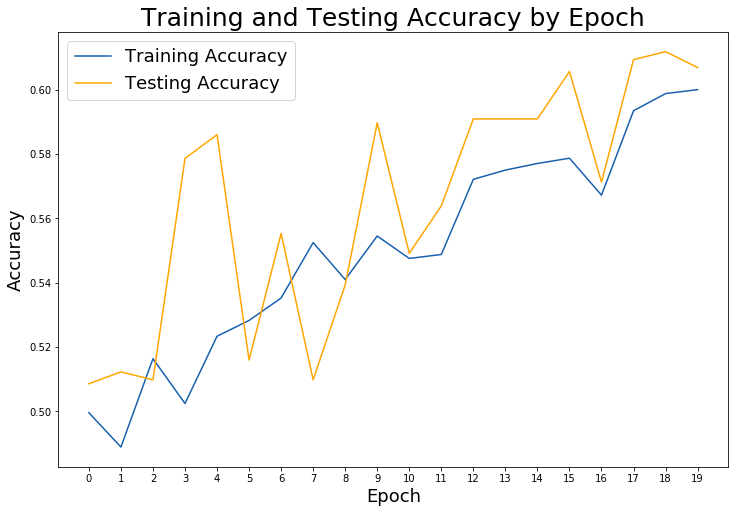

In [51]:
# Check out our train loss and test loss over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

In [52]:
# Evaluate model on test data.
cnn_4_score = cnn_model_4.evaluate(X_test,
                                   y_test,
                                   verbose=1)

cnn_4_labels = cnn_model_4.metrics_names

# Compare models.
print(f'CNN 4 {cnn_4_labels[0]}  : {cnn_4_score[0]}')
print(f'CNN 4 {cnn_4_labels[1]}   : {cnn_4_score[1]}')
print()
print(f'CNN 3 {cnn_3_labels[0]}  : {cnn_3_score[0]}')
print(f'CNN 3 {cnn_3_labels[1]}   : {cnn_3_score[1]}')
print()
print(f'CNN 2 {cnn_2_labels[0]}  : {cnn_2_score[0]}')
print(f'CNN 2 {cnn_2_labels[1]}   : {cnn_2_score[1]}')
print()
print(f'CNN 1 {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN 1 {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

814/814 [==============================] - 0s 50us/step
CNN 4 loss  : 0.6601010634213759
CNN 4 acc   : 0.6068796067331581

CNN 3 loss  : 0.6651415101433269
CNN 3 acc   : 0.6363636362171876

CNN 2 loss  : 0.6678012013435364
CNN 2 acc   : 0.6068796067331581

CNN 1 loss  : 0.6831595730722976
CNN 1 acc   : 0.5921375925769384

FFNN loss : 0.6649565991078313
FFNN acc  : 0.6068796073189532
